__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.patches as mpatches  # create custom plot legends
import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from matplotlib.lines import Line2D  # matplotlib custom lines
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
from scipy import stats  # statistical tests
from sklearn.decomposition import PCA  # principal component analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # run LDA
from sklearn.preprocessing import StandardScaler  # scale data before PCA
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
warnings.filterwarnings("ignore")
# set default float display format to 2 decimals
pd.options.display.float_format = "{:.3f}".format

STYLE = "whitegrid"
sns.set(rc={"figure.figsize": (20, 8)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

PATH_PROC = "./data/processed"

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

"""
Event1: 1162-1400
Event2: 1958-2080
Event3: 2596-2890
"""
event_ranges = [(1162, 1400), (1958, 2080), (2596, 2890)]

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


__Read participants cleaned data__

In [3]:
parts = pd.read_csv("./participants_clean.csv", keep_default_na=False)
parts = parts.set_index("id")  # set uid column as index (remove default)
parts

,date,expo,side,condition,questionnaire,nulls_%
id,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,No,1.610
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,No,0.037
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,No,0.037
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,No,0.824
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,No,0.225
...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,No,0.300
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,No,0.674
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,No,1.797


In [4]:
quests = pd.read_csv("./questionnaires.csv", keep_default_na=False)
quests = quests.set_index("id")  # set uid column as index (remove default)
quests

,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,side,condition
id,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,2019-05-26 12:06:22,50,50,50,50,intersex,25,1,80,58,more than 10 times,MSW,right,RadioTalk
1fbde03890d94bddaf7aa987fc732607,2019-05-26 16:02:45,100,100,100,96,Male,13,0,0,5,once,MSW,left,RadioTalk
1ad9eea672a94518b150925bac41fcbc,2019-05-26 17:23:38,17,22,0,86,Female,24,0,4,2,once,MSW,right,RadioTalk
461b2d80132f47958e50003c16084cf4,2019-05-26 17:27:34,30,70,80,80,Male,22,0,3,1,less than 10 times,MSW,right,TaxiDriver
4f300efb4a9941f7a96f57e8030b12e2,2019-05-26 17:39:25,100,100,50,50,Male,16,0,0,3,less than 10 times,MSW,right,RadioTalk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,0,0,25,once,BMBF,right,RadioTalk
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,1,99,9,less than 10 times,BMBF,right,TaxiDriver
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,0,39,0,never,BMBF,right,RadioTalk


In [5]:
hit_levs = pd.read_csv(f"./group_length_percentages.csv", index_col=0)
hit_levs

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,31.366,1.574,1.911,3.204,6.127,31.141,0.000,0.000,1.967,22.709,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,0.915,0.000,44.179,0.458,46.772,0.000,0.000,0.559,7.117,0.000
8598a83e2af441b8bcd0ae5d84beb875,77.503,0.000,0.000,1.268,1.869,0.000,0.000,0.000,0.734,18.625,0.000
37d7e67934974217830bb429bba7fd76,32.626,4.741,2.121,8.921,9.545,2.121,0.624,0.000,3.805,35.496,0.000
42bac596059749b5b8e8e83ae61de9b4,63.825,0.000,0.000,0.974,11.815,0.000,0.000,0.000,4.263,19.123,0.000
...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,64.702,0.000,0.000,12.226,5.204,0.000,0.000,0.000,1.944,15.925,0.000
611d35a7c3e940cc82495e53c2a8532d,30.988,0.000,0.000,39.527,7.626,4.619,0.000,0.000,1.719,14.930,0.591
3b6fda285d9e412eb081986b2f22a2e3,13.843,0.000,0.818,32.535,1.168,29.381,0.000,1.986,10.397,9.871,0.000
18ffb0abdc8642098c479380bfa533d1,32.460,0.582,0.000,12.082,10.917,14.119,0.000,0.000,3.275,25.182,1.383


In [6]:
hit_cevs = pd.read_csv(f"./group_counts_percentages.csv", index_col=0)
hit_cevs

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,34.328,2.985,1.493,4.478,11.940,28.358,0.000,0.000,5.970,10.448,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,2.500,0.000,52.500,1.250,40.000,0.000,0.000,1.250,2.500,0.000
8598a83e2af441b8bcd0ae5d84beb875,64.865,0.000,0.000,5.405,8.108,0.000,0.000,0.000,2.703,18.919,0.000
37d7e67934974217830bb429bba7fd76,37.681,4.348,1.449,14.493,15.942,5.797,1.449,0.000,8.696,10.145,0.000
42bac596059749b5b8e8e83ae61de9b4,57.143,0.000,0.000,2.857,20.000,0.000,0.000,0.000,7.143,12.857,0.000
...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,62.687,0.000,0.000,13.433,8.955,0.000,0.000,0.000,2.985,11.940,0.000
611d35a7c3e940cc82495e53c2a8532d,33.929,0.000,0.000,32.143,14.286,7.143,0.000,0.000,5.357,5.357,1.786
3b6fda285d9e412eb081986b2f22a2e3,11.765,0.000,1.176,30.588,2.353,34.118,0.000,2.353,10.588,7.059,0.000
18ffb0abdc8642098c479380bfa533d1,31.169,1.299,0.000,16.883,15.584,12.987,0.000,0.000,5.195,14.286,2.597


In [7]:
hit_levs = hit_levs.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
hit_levs

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs,expo,side,condition,questionnaire
4f583872ffed48249874b00f3d389cfc,31.366,1.574,1.911,3.204,6.127,31.141,0.000,0.000,1.967,22.709,0.000,MSW,right,TaxiDriver,No
33d68ad55ef544fab9fd08108e3913ca,0.000,0.915,0.000,44.179,0.458,46.772,0.000,0.000,0.559,7.117,0.000,MSW,right,AVAS,No
8598a83e2af441b8bcd0ae5d84beb875,77.503,0.000,0.000,1.268,1.869,0.000,0.000,0.000,0.734,18.625,0.000,MSW,right,RadioTalk,No
37d7e67934974217830bb429bba7fd76,32.626,4.741,2.121,8.921,9.545,2.121,0.624,0.000,3.805,35.496,0.000,MSW,left,AVAS,No
42bac596059749b5b8e8e83ae61de9b4,63.825,0.000,0.000,0.974,11.815,0.000,0.000,0.000,4.263,19.123,0.000,MSW,right,TaxiDriver,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,64.702,0.000,0.000,12.226,5.204,0.000,0.000,0.000,1.944,15.925,0.000,BMBF,right,AVAS,No
611d35a7c3e940cc82495e53c2a8532d,30.988,0.000,0.000,39.527,7.626,4.619,0.000,0.000,1.719,14.930,0.591,BMBF,right,TaxiDriver,No
3b6fda285d9e412eb081986b2f22a2e3,13.843,0.000,0.818,32.535,1.168,29.381,0.000,1.986,10.397,9.871,0.000,BMBF,left,AVAS,No
18ffb0abdc8642098c479380bfa533d1,32.460,0.582,0.000,12.082,10.917,14.119,0.000,0.000,3.275,25.182,1.383,BMBF,left,RadioTalk,Yes


In [8]:
hit_cevs = hit_cevs.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
hit_cevs

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs,expo,side,condition,questionnaire
4f583872ffed48249874b00f3d389cfc,34.328,2.985,1.493,4.478,11.940,28.358,0.000,0.000,5.970,10.448,0.000,MSW,right,TaxiDriver,No
33d68ad55ef544fab9fd08108e3913ca,0.000,2.500,0.000,52.500,1.250,40.000,0.000,0.000,1.250,2.500,0.000,MSW,right,AVAS,No
8598a83e2af441b8bcd0ae5d84beb875,64.865,0.000,0.000,5.405,8.108,0.000,0.000,0.000,2.703,18.919,0.000,MSW,right,RadioTalk,No
37d7e67934974217830bb429bba7fd76,37.681,4.348,1.449,14.493,15.942,5.797,1.449,0.000,8.696,10.145,0.000,MSW,left,AVAS,No
42bac596059749b5b8e8e83ae61de9b4,57.143,0.000,0.000,2.857,20.000,0.000,0.000,0.000,7.143,12.857,0.000,MSW,right,TaxiDriver,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,62.687,0.000,0.000,13.433,8.955,0.000,0.000,0.000,2.985,11.940,0.000,BMBF,right,AVAS,No
611d35a7c3e940cc82495e53c2a8532d,33.929,0.000,0.000,32.143,14.286,7.143,0.000,0.000,5.357,5.357,1.786,BMBF,right,TaxiDriver,No
3b6fda285d9e412eb081986b2f22a2e3,11.765,0.000,1.176,30.588,2.353,34.118,0.000,2.353,10.588,7.059,0.000,BMBF,left,AVAS,No
18ffb0abdc8642098c479380bfa533d1,31.169,1.299,0.000,16.883,15.584,12.987,0.000,0.000,5.195,14.286,2.597,BMBF,left,RadioTalk,Yes


In [9]:
display(hit_levs.describe())
display(hit_cevs.describe())

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,27.564,0.785,0.488,33.460,4.701,17.761,0.052,0.056,2.084,12.755,0.294
std,23.119,1.466,0.946,26.096,4.732,18.454,0.256,0.309,2.306,6.499,0.926
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.582,0.000,0.000,10.501,0.598,3.208,0.000,0.000,0.000,7.151,0.000
50%,24.284,0.000,0.000,27.525,3.375,12.281,0.000,0.000,1.407,12.174,0.000
75%,47.656,0.991,0.666,54.332,7.546,26.242,0.000,0.000,3.197,17.329,0.000
max,84.044,14.747,17.388,100.000,32.171,100.000,5.383,8.671,27.878,40.564,13.337


,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,27.546,1.114,0.935,33.862,7.484,17.303,0.096,0.092,3.654,7.381,0.533
std,20.876,1.766,1.547,23.273,6.677,15.334,0.423,0.413,3.739,4.077,1.528
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,7.353,0.000,0.000,13.924,1.429,4.348,0.000,0.000,0.000,4.000,0.000
50%,26.087,0.000,0.000,30.303,6.250,14.103,0.000,0.000,2.778,7.143,0.000
75%,45.783,1.538,1.471,52.857,12.069,26.667,0.000,0.000,5.479,10.169,0.000
max,84.375,15.625,19.753,100.000,39.080,100.000,6.349,5.882,39.474,35.714,18.033


Final Groups

In [10]:
final_groups = ["Buildings", "Inside Car", "Nature", "condition"]
# length
gaze_levs = hit_levs[final_groups]
gaze_levs["Cars and Pedestrians"] = (
    hit_levs["Dynamic Cars"] + hit_levs["Dynamic Pedestrians"]
)
gaze_levs["Roads"] = hit_levs["Static Cars"] + hit_levs["Roads"]
gaze_levs["Street Objects"] = (
    hit_levs["Street Objects"] + hit_levs["Static Pedestrians"]
)
gaze_levs["Traffic Signs"] = (
    hit_levs["Traffic Signs"] + hit_levs["Traffic Lights"]
)

# count
gaze_cevs = hit_cevs[final_groups]
gaze_cevs["Cars and Pedestrians"] = (
    hit_cevs["Dynamic Cars"] + hit_cevs["Dynamic Pedestrians"]
)
gaze_cevs["Roads"] = hit_cevs["Static Cars"] + hit_cevs["Roads"]
gaze_cevs["Street Objects"] = (
    hit_cevs["Street Objects"] + hit_cevs["Static Pedestrians"]
)
gaze_cevs["Traffic Signs"] = (
    hit_cevs["Traffic Signs"] + hit_cevs["Traffic Lights"]
)

# TR vs non-TR
gaze_ltr = pd.DataFrame(columns=["TR", "non-TR"])
gaze_ltr["TR"] = (
    gaze_levs["Cars and Pedestrians"]
    + gaze_levs["Roads"]
    + gaze_levs["Traffic Signs"]
)
gaze_ltr["non-TR"] = (
    gaze_levs["Buildings"] + gaze_levs["Nature"] + gaze_levs["Street Objects"]
)
gaze_ltr["condition"] = gaze_levs["condition"]
gaze_ctr = pd.DataFrame(columns=["TR", "non-TR"])
gaze_ctr["TR"] = (
    gaze_cevs["Cars and Pedestrians"]
    + gaze_cevs["Roads"]
    + gaze_cevs["Traffic Signs"]
)
gaze_ctr["non-TR"] = (
    gaze_cevs["Buildings"] + gaze_cevs["Nature"] + gaze_cevs["Street Objects"]
)
gaze_ctr["condition"] = gaze_cevs["condition"]

In [11]:
gaze_levs.sum(axis=1)

4f583872ffed48249874b00f3d389cfc   100.000
33d68ad55ef544fab9fd08108e3913ca   100.000
8598a83e2af441b8bcd0ae5d84beb875   100.000
37d7e67934974217830bb429bba7fd76   100.000
42bac596059749b5b8e8e83ae61de9b4   100.000
                                     ...  
cfe9482181f74f80b88cd4b1c048ab94   100.000
611d35a7c3e940cc82495e53c2a8532d   100.000
3b6fda285d9e412eb081986b2f22a2e3   100.000
18ffb0abdc8642098c479380bfa533d1   100.000
c06f123b35b74bb489ec239b1cac9eb4   100.000
Length: 24356, dtype: float64

In [12]:
gaze_cevs.sum(axis=1)

4f583872ffed48249874b00f3d389cfc   100.000
33d68ad55ef544fab9fd08108e3913ca   100.000
8598a83e2af441b8bcd0ae5d84beb875   100.000
37d7e67934974217830bb429bba7fd76   100.000
42bac596059749b5b8e8e83ae61de9b4   100.000
                                     ...  
cfe9482181f74f80b88cd4b1c048ab94   100.000
611d35a7c3e940cc82495e53c2a8532d   100.000
3b6fda285d9e412eb081986b2f22a2e3   100.000
18ffb0abdc8642098c479380bfa533d1   100.000
c06f123b35b74bb489ec239b1cac9eb4   100.000
Length: 24356, dtype: float64

In [13]:
gaze_ltr.sum(axis=1)

4f583872ffed48249874b00f3d389cfc   96.796
33d68ad55ef544fab9fd08108e3913ca   55.821
8598a83e2af441b8bcd0ae5d84beb875   98.732
37d7e67934974217830bb429bba7fd76   91.079
42bac596059749b5b8e8e83ae61de9b4   99.026
                                    ...  
cfe9482181f74f80b88cd4b1c048ab94   87.774
611d35a7c3e940cc82495e53c2a8532d   60.473
3b6fda285d9e412eb081986b2f22a2e3   67.465
18ffb0abdc8642098c479380bfa533d1   87.918
c06f123b35b74bb489ec239b1cac9eb4   41.118
Length: 24356, dtype: float64

In [14]:
gaze_ctr.sum(axis=1)

4f583872ffed48249874b00f3d389cfc   95.522
33d68ad55ef544fab9fd08108e3913ca   47.500
8598a83e2af441b8bcd0ae5d84beb875   94.595
37d7e67934974217830bb429bba7fd76   85.507
42bac596059749b5b8e8e83ae61de9b4   97.143
                                    ...  
cfe9482181f74f80b88cd4b1c048ab94   86.567
611d35a7c3e940cc82495e53c2a8532d   67.857
3b6fda285d9e412eb081986b2f22a2e3   69.412
18ffb0abdc8642098c479380bfa533d1   83.117
c06f123b35b74bb489ec239b1cac9eb4   42.857
Length: 24356, dtype: float64

Fix percentages for TR vs non-TR gaze lengths

In [15]:
new_gaze_ltr = copy.deepcopy(gaze_ltr)
cols = new_gaze_ltr.columns.difference(["condition"])
uids = new_gaze_ltr.index.tolist()

# participants progress bar
uids_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for uid in uids_pbar:
    sel = new_gaze_ltr.loc[uid]
    actual = sel[cols].sum()
    for c in cols:
        if sel[c] != 0:
            cur = sel[c]
            corrected = cur * 100 / actual
            sel[c] = corrected
    new_gaze_ltr.loc[uid] = sel

📄 0 of 24356 📂 participants processed:                                                                        …

Fix percentages for TR vs non-TR gaze counts

In [16]:
new_gaze_ctr = copy.deepcopy(gaze_ctr)
cols = new_gaze_ctr.columns.difference(["condition"])
uids = new_gaze_ctr.index.tolist()

# participants progress bar
uids_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for uid in uids_pbar:
    sel = new_gaze_ctr.loc[uid]
    actual = sel[cols].sum()
    for c in cols:
        if sel[c] != 0:
            cur = sel[c]
            corrected = cur * 100 / actual
            sel[c] = corrected
    new_gaze_ctr.loc[uid] = sel

📄 0 of 24356 📂 participants processed:                                                                        …

In [17]:
new_gaze_ltr.sum(axis=1)

4f583872ffed48249874b00f3d389cfc   100.000
33d68ad55ef544fab9fd08108e3913ca   100.000
8598a83e2af441b8bcd0ae5d84beb875   100.000
37d7e67934974217830bb429bba7fd76   100.000
42bac596059749b5b8e8e83ae61de9b4   100.000
                                     ...  
cfe9482181f74f80b88cd4b1c048ab94   100.000
611d35a7c3e940cc82495e53c2a8532d   100.000
3b6fda285d9e412eb081986b2f22a2e3   100.000
18ffb0abdc8642098c479380bfa533d1   100.000
c06f123b35b74bb489ec239b1cac9eb4   100.000
Length: 24356, dtype: float64

In [18]:
new_gaze_ctr.sum(axis=1)

4f583872ffed48249874b00f3d389cfc   100.000
33d68ad55ef544fab9fd08108e3913ca   100.000
8598a83e2af441b8bcd0ae5d84beb875   100.000
37d7e67934974217830bb429bba7fd76   100.000
42bac596059749b5b8e8e83ae61de9b4   100.000
                                     ...  
cfe9482181f74f80b88cd4b1c048ab94   100.000
611d35a7c3e940cc82495e53c2a8532d   100.000
3b6fda285d9e412eb081986b2f22a2e3   100.000
18ffb0abdc8642098c479380bfa533d1   100.000
c06f123b35b74bb489ec239b1cac9eb4   100.000
Length: 24356, dtype: float64

In [19]:
new_gaze_ltr.isnull().sum()

TR           0
non-TR       0
condition    0
dtype: int64

In [20]:
new_gaze_ctr.isnull().sum()

TR           0
non-TR       0
condition    0
dtype: int64

Replace wrong with corrected

In [21]:
gaze_ltr.isnull().sum()

TR           0
non-TR       0
condition    0
dtype: int64

In [22]:
gaze_ctr.isnull().sum()

TR           0
non-TR       0
condition    0
dtype: int64

In [23]:
gaze_ltr = new_gaze_ltr
gaze_ctr = new_gaze_ctr

In [24]:
gaze_ltr.sum(axis=1)

4f583872ffed48249874b00f3d389cfc   100.000
33d68ad55ef544fab9fd08108e3913ca   100.000
8598a83e2af441b8bcd0ae5d84beb875   100.000
37d7e67934974217830bb429bba7fd76   100.000
42bac596059749b5b8e8e83ae61de9b4   100.000
                                     ...  
cfe9482181f74f80b88cd4b1c048ab94   100.000
611d35a7c3e940cc82495e53c2a8532d   100.000
3b6fda285d9e412eb081986b2f22a2e3   100.000
18ffb0abdc8642098c479380bfa533d1   100.000
c06f123b35b74bb489ec239b1cac9eb4   100.000
Length: 24356, dtype: float64

In [25]:
gaze_ctr.sum(axis=1)

4f583872ffed48249874b00f3d389cfc   100.000
33d68ad55ef544fab9fd08108e3913ca   100.000
8598a83e2af441b8bcd0ae5d84beb875   100.000
37d7e67934974217830bb429bba7fd76   100.000
42bac596059749b5b8e8e83ae61de9b4   100.000
                                     ...  
cfe9482181f74f80b88cd4b1c048ab94   100.000
611d35a7c3e940cc82495e53c2a8532d   100.000
3b6fda285d9e412eb081986b2f22a2e3   100.000
18ffb0abdc8642098c479380bfa533d1   100.000
c06f123b35b74bb489ec239b1cac9eb4   100.000
Length: 24356, dtype: float64

In [26]:
gaze_levs.describe()

,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,27.564,33.460,4.701,1.273,17.812,2.141,13.049
std,23.119,26.096,4.732,1.930,18.457,2.367,6.765
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.582,10.501,0.598,0.000,3.291,0.000,7.273
50%,24.284,27.525,3.375,0.561,12.327,1.449,12.453
75%,47.656,54.332,7.546,1.714,26.295,3.276,17.677
max,84.044,100.000,32.171,19.054,100.000,29.047,45.845


In [27]:
gaze_cevs.describe()

,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,27.546,33.862,7.484,2.049,17.399,3.746,7.914
std,20.876,23.273,6.677,2.636,15.340,3.815,4.550
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,7.353,13.924,1.429,0.000,4.469,0.000,4.225
50%,26.087,30.303,6.250,1.351,14.286,2.857,7.576
75%,45.783,52.857,12.069,3.030,26.761,5.634,10.909
max,84.375,100.000,39.080,20.988,100.000,40.789,35.714


In [28]:
gaze_levs

,Buildings,Inside Car,Nature,condition,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
4f583872ffed48249874b00f3d389cfc,31.366,3.204,6.127,TaxiDriver,3.485,31.141,1.967,22.709
33d68ad55ef544fab9fd08108e3913ca,0.000,44.179,0.458,AVAS,0.915,46.772,0.559,7.117
8598a83e2af441b8bcd0ae5d84beb875,77.503,1.268,1.869,RadioTalk,0.000,0.000,0.734,18.625
37d7e67934974217830bb429bba7fd76,32.626,8.921,9.545,AVAS,6.862,2.745,3.805,35.496
42bac596059749b5b8e8e83ae61de9b4,63.825,0.974,11.815,TaxiDriver,0.000,0.000,4.263,19.123
...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,64.702,12.226,5.204,AVAS,0.000,0.000,1.944,15.925
611d35a7c3e940cc82495e53c2a8532d,30.988,39.527,7.626,TaxiDriver,0.000,4.619,1.719,15.521
3b6fda285d9e412eb081986b2f22a2e3,13.843,32.535,1.168,AVAS,0.818,29.381,12.383,9.871
18ffb0abdc8642098c479380bfa533d1,32.460,12.082,10.917,RadioTalk,0.582,14.119,3.275,26.565


In [94]:
def scatter_matrix(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    scaled = pd.DataFrame(data=x, columns=features)
    display(scaled)
    scaled_full = pd.concat([scaled, df.reset_index()[target]], axis=1)
    display(scaled_full)

    # ax = sns.pairplot(scaled_full, hue="condition", plot_kws={"alpha": 0.01})
    ax = sns.pairplot(
        scaled_full,
        hue="condition",
        kind="reg",
        # plot_kws={"levels": 1},
        plot_kws={"scatter_kws": {"alpha": 0.01}},
        corner=True,
    )
    for lh in ax._legend.legendHandles:
        lh.set_alpha(1)
    # ax.set(xlim=[-3,1], ylim=[-1,1])
    plt.show()

In [ ]:
def pca_scatter_matrix(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    scaled = pd.DataFrame(data=x, columns=features)
    display(scaled)
    scaled_full = pd.concat([scaled, df.reset_index()[target]], axis=1)
    display(scaled_full)

    # prepare 2D PCA projection
    pca = PCA()
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(
        data=principalComponents,
        columns=["PC1", "PC2"],
    )

    # ax = sns.pairplot(scaled_full, hue="condition", plot_kws={"alpha": 0.01})
    ax = sns.pairplot(scaled_full, hue="condition", kind="kde")
    plt.show()

SyntaxError: invalid syntax (3389593442.py, line 28)

Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.164,-1.159,0.301,1.146,0.722,-0.073,1.428
1,-1.192,0.411,-0.897,-0.185,1.569,-0.668,-0.877
2,2.160,-1.234,-0.598,-0.659,-0.965,-0.594,0.824
3,0.219,-0.940,1.023,2.896,-0.816,0.703,3.318
4,1.568,-1.245,1.503,-0.659,-0.965,0.897,0.898
...,...,...,...,...,...,...,...
24351,1.606,-0.814,0.106,-0.659,-0.965,-0.083,0.425
24352,0.148,0.233,0.618,-0.659,-0.715,-0.178,0.365
24353,-0.594,-0.035,-0.747,-0.236,0.627,4.328,-0.470
24354,0.212,-0.819,1.313,-0.358,-0.200,0.479,1.998


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs,condition
0,0.164,-1.159,0.301,1.146,0.722,-0.073,1.428,TaxiDriver
1,-1.192,0.411,-0.897,-0.185,1.569,-0.668,-0.877,AVAS
2,2.160,-1.234,-0.598,-0.659,-0.965,-0.594,0.824,RadioTalk
3,0.219,-0.940,1.023,2.896,-0.816,0.703,3.318,AVAS
4,1.568,-1.245,1.503,-0.659,-0.965,0.897,0.898,TaxiDriver
...,...,...,...,...,...,...,...,...
24351,1.606,-0.814,0.106,-0.659,-0.965,-0.083,0.425,AVAS
24352,0.148,0.233,0.618,-0.659,-0.715,-0.178,0.365,TaxiDriver
24353,-0.594,-0.035,-0.747,-0.236,0.627,4.328,-0.470,AVAS
24354,0.212,-0.819,1.313,-0.358,-0.200,0.479,1.998,RadioTalk


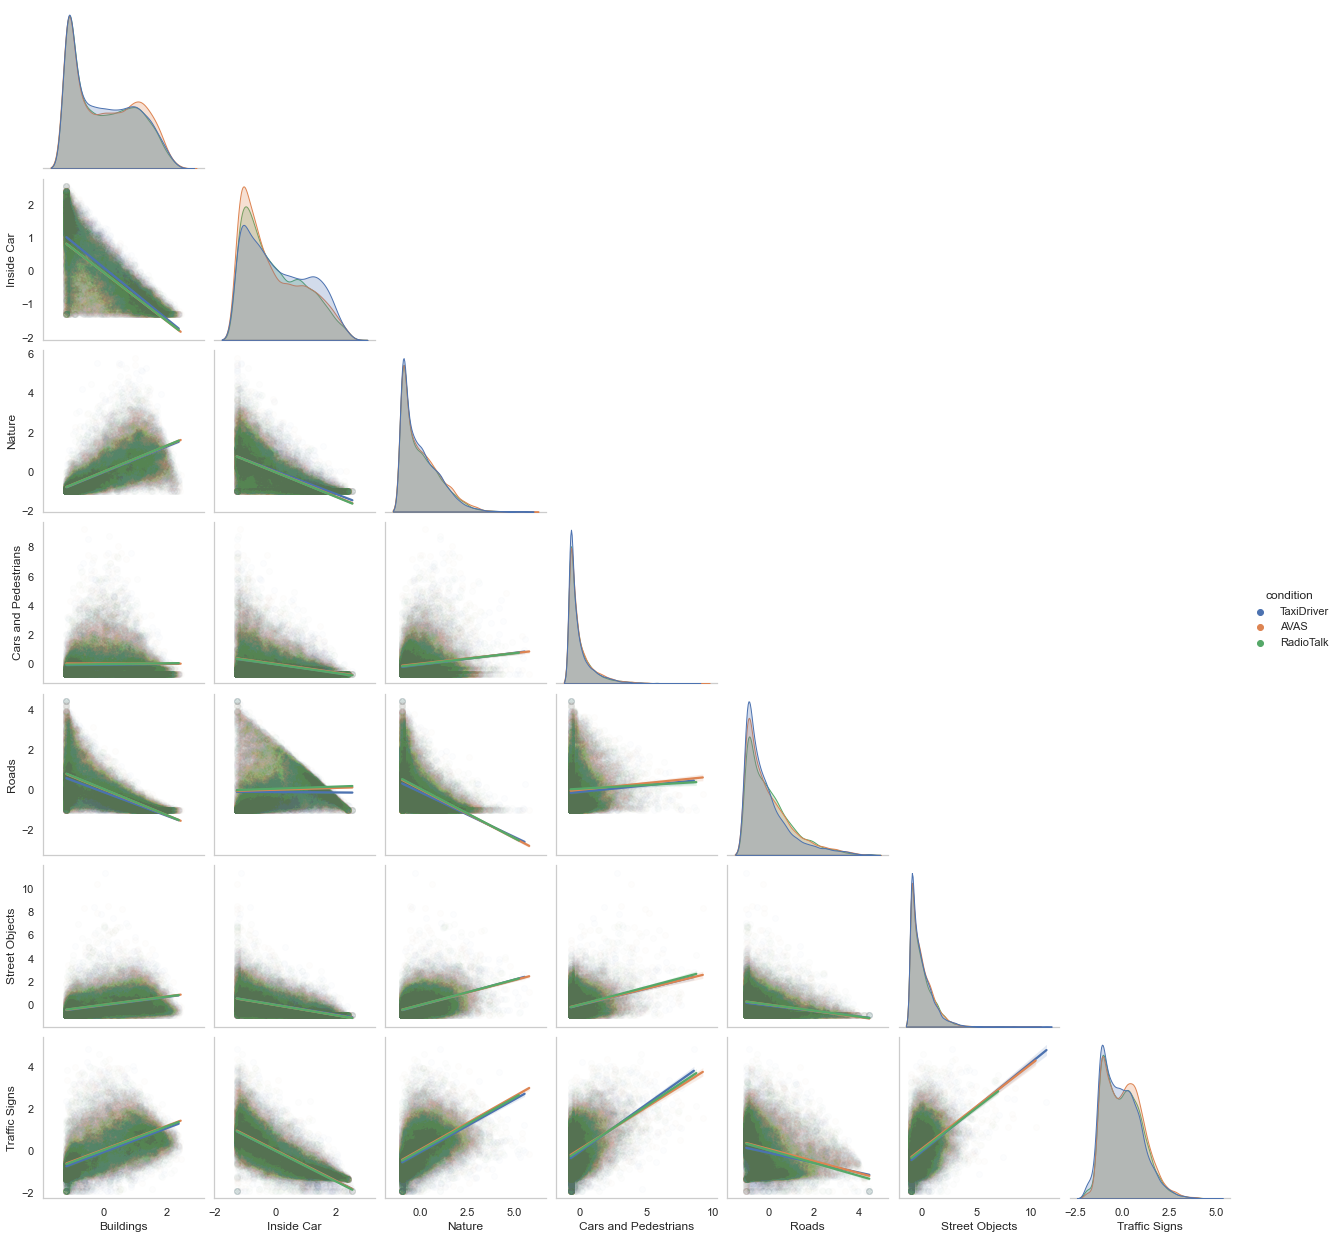

In [95]:
sns.set_style("whitegrid", {"axes.grid": False})
plt.figure(figsize=(100, 100))
# set non-interactive plot (default)
%matplotlib inline
scatter_matrix(gaze_levs, "(gaze lengthts)")
# scatter_matrix(gaze_cevs, "(gaze counts)")

__PCA all components__

In [29]:
def pca_full(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    scaled = pd.DataFrame(data=x, columns=features)
    display(scaled)

    # prepare 2D PCA projection
    pca = PCA()
    pca = pca.fit(x)
    loadings = pca.components_
    num_pc = pca.n_features_
    pc_list = [f"PC{i}" for i in list(range(1, num_pc + 1))]
    loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
    loadings_df["variable"] = scaled.columns.values
    loadings_df = loadings_df.set_index("variable")
    display(loadings_df)

    # plt.figure(figsize=(10, 8))
    # ax = sns.heatmap(loadings_df, annot=True, cmap="Spectral")

    from bioinfokit.visuz import cluster

    # cluster.screeplot(obj=[pc_list, pca.explained_variance_ratio_])
    # get PCA loadings plots (2D and 3D)
    # 2D
    cluster.pcaplot(
        x=loadings[0],
        y=loadings[1],
        labels=scaled.columns.values,
        var1=round(pca.explained_variance_ratio_[0] * 100, 2),
        var2=round(pca.explained_variance_ratio_[1] * 100, 2),
    )

    # 3D
    cluster.pcaplot(
        x=loadings[0],
        y=loadings[1],
        z=loadings[2],
        labels=scaled.columns.values,
        var1=round(pca.explained_variance_ratio_[0] * 100, 2),
        var2=round(pca.explained_variance_ratio_[1] * 100, 2),
        var3=round(pca.explained_variance_ratio_[2] * 100, 2),
    )

    #     principalDf = pd.DataFrame(
    #         data=principalComponents,
    #         columns=["PC1", "PC2"],
    #     )
    #     print("Preview projected values:")
    #     display(principalDf.head(5))
    #     print("Include target value:")
    #     finalDf = pd.concat([principalDf, df.reset_index()[target]], axis=1)
    #     display(finalDf.head(5))

    #     # visualize the 2D projected data
    #     fig = plt.figure(figsize=(8, 8))
    #     ax = fig.add_subplot(1, 1, 1)
    #     ax.set_xlabel("PC1", fontsize=15)
    #     ax.set_ylabel("PC2", fontsize=15)
    #     ax.set_title(f"2 Component PCA {title}", fontsize=20)
    #     targets = df.condition.unique()
    #     colors = ["r", "g", "b"]
    #     for target, color in zip(targets, colors):
    #         indicesToKeep = finalDf["condition"] == target
    #         ax.scatter(
    #             finalDf.loc[indicesToKeep, "PC1"],
    #             finalDf.loc[indicesToKeep, "PC2"],
    #             c=color,
    #             s=50,
    #             alpha=0.01,
    #         )
    #     ax.legend(targets)
    #     ax.grid()
    #     plt.show()
    # show the variance explained by the componentsc
    plt.show()
    print(f"PCA variance ({pc_list}): {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_)}")

__Compute and project PCA (2D, 2 components) over subjects__

In [30]:
np.set_printoptions(suppress=True)

# set non-interactive plot (default)
%matplotlib inline
print("PCA full over subjects for gaze lengthts:")
pca_full(gaze_levs, "(gaze lengthts)")
print()
print("PCA full over subjects for gaze counts:")
pca_full(gaze_cevs, "(gaze counts)")

PCA full over subjects for gaze lengthts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.164,-1.159,0.301,1.146,0.722,-0.073,1.428
1,-1.192,0.411,-0.897,-0.185,1.569,-0.668,-0.877
2,2.160,-1.234,-0.598,-0.659,-0.965,-0.594,0.824
3,0.219,-0.940,1.023,2.896,-0.816,0.703,3.318
4,1.568,-1.245,1.503,-0.659,-0.965,0.897,0.898


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
variable,,,,,,,
Buildings,0.456,-0.309,-0.228,-0.100,-0.171,-0.528,0.572
Inside Car,-0.444,-0.232,0.507,-0.115,0.019,0.248,0.646
Nature,0.432,-0.168,-0.024,0.074,0.809,0.333,0.117
Cars and Pedestrians,0.185,0.634,0.448,-0.445,0.219,-0.339,0.048
Roads,-0.275,0.585,-0.498,0.321,0.148,0.022,0.457
Street Objects,0.334,0.152,0.482,0.767,-0.201,-0.026,0.059
Traffic Signs,0.432,0.238,-0.095,-0.284,-0.453,0.658,0.167


PCA variance (['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']): [0.50291223 0.19193069 0.11520006 0.09045755 0.05909376 0.04040572
 0.        ]
Total variance explained: 1.0

PCA full over subjects for gaze counts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.325,-1.263,0.667,0.922,0.714,0.583,0.557
1,-1.320,0.801,-0.934,0.171,1.473,-0.654,-1.190
2,1.788,-1.223,0.094,-0.777,-1.134,-0.274,2.419
3,0.485,-0.832,1.267,1.422,-0.662,1.297,0.490
4,1.418,-1.332,1.875,-0.777,-1.134,0.890,1.086


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
variable,,,,,,,
Buildings,0.454,-0.296,-0.164,0.075,-0.079,-0.577,-0.579
Inside Car,-0.461,-0.195,0.277,0.247,0.330,0.294,-0.646
Nature,0.436,-0.151,0.057,0.067,-0.540,0.673,-0.185
Cars and Pedestrians,0.167,0.679,0.351,0.590,-0.108,-0.151,-0.073
Roads,-0.332,0.516,-0.276,-0.466,-0.386,-0.027,-0.426
Street Objects,0.354,0.148,0.629,-0.603,0.287,0.011,-0.106
Traffic Signs,0.359,0.320,-0.546,0.030,0.591,0.323,-0.126


PCA variance (['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']): [0.53349856 0.18876269 0.09517312 0.07931747 0.06376562 0.03948255
 0.        ]
Total variance explained: 1.0


__PCA and LDA 2D (2 components) functions__

In [31]:
def pca_2d(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    display(pd.DataFrame(data=x, columns=features).head())

    # prepare 2D PCA projection
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(
        data=principalComponents,
        columns=["PC1", "PC2"],
    )
    print("Preview projected values:")
    display(principalDf.head(5))
    print("Include target value:")
    finalDf = pd.concat([principalDf, df.reset_index()[target]], axis=1)
    display(finalDf.head(5))

    # visualize the 2D projected data
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("PC1", fontsize=15)
    ax.set_ylabel("PC2", fontsize=15)
    ax.set_title(f"2 Component PCA {title}", fontsize=20)
    targets = df.condition.unique()
    colors = ["r", "g", "b"]
    for target, color in zip(targets, colors):
        indicesToKeep = finalDf["condition"] == target
        ax.scatter(
            finalDf.loc[indicesToKeep, "PC1"],
            finalDf.loc[indicesToKeep, "PC2"],
            c=color,
            s=50,
            alpha=0.01,
        )
    ax.legend(targets)
    ax.grid()
    plt.show()
    # show the variance explained by the componentsc
    print(f"PCA variance ([PC1, PC2]): {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_)}")


def lda_2d(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    display(pd.DataFrame(data=x, columns=features).head())

    # prepare 2D LDA projection
    lda = LinearDiscriminantAnalysis(n_components=2)
    x = lda.fit_transform(x, y)
    ldaDf = pd.DataFrame(
        data=x,
        columns=["LD1", "LD2"],
    )
    print("Preview projected values:")
    display(ldaDf.head(5))
    print("Include target value:")
    ldaDf = pd.concat([ldaDf, df.reset_index()[target]], axis=1)
    display(ldaDf.head(5))

    # visualize the 2D projected data
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("LD1", fontsize=15)
    ax.set_ylabel("LD2", fontsize=15)
    ax.set_title(f"2 Component LDA {title}", fontsize=20)
    targets = df.condition.unique()
    colors = ["r", "g", "b"]
    for target, color in zip(targets, colors):
        indicesToKeep = ldaDf["condition"] == target
        ax.scatter(
            ldaDf.loc[indicesToKeep, "LD1"],
            ldaDf.loc[indicesToKeep, "LD2"],
            c=color,
            s=50,
            alpha=0.01,
        )
    ax.legend(targets)
    ax.grid()
    plt.show()
    # show the variance explained by the componentsc
    print(f"LDA variance ([LD1, LD2]): {lda.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(lda.explained_variance_ratio_)}")

__PCA and LDA 3D (3 components) functions__

In [32]:
def pca_3d(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    display(pd.DataFrame(data=x, columns=features).head())

    # prepare 3D PCA projection
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(
        data=principalComponents,
        columns=["PC1", "PC2", "PC3"],
    )
    print("Preview projected values:")
    display(principalDf.head(5))
    print("Include target value:")
    finalDf = pd.concat([principalDf, df.reset_index()[target]], axis=1)
    display(finalDf.head(5))

    # visualize the 3D projected data
    Xax = finalDf.PC1
    Yax = finalDf.PC2
    Zax = finalDf.PC3

    targets = df.condition.unique()
    cdict = {targets[0]: "red", targets[1]: "green", targets[2]: "blue"}
    labl = {
        targets[0]: targets[0],
        targets[1]: targets[1],
        targets[2]: targets[2],
    }
    marker = {targets[0]: "o", targets[1]: "o", targets[2]: "o"}
    alpha = {targets[0]: 0.01, targets[1]: 0.01, targets[2]: 0.01}

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    fig.patch.set_facecolor("white")
    for l in targets:
        ix = finalDf[finalDf.condition == l].index
        ax.scatter(
            Xax[ix],
            Yax[ix],
            Zax[ix],
            c=cdict[l],
            s=40,
            label=labl[l],
            marker=marker[l],
            alpha=alpha[l],
        )
    # for loop ends
    ax.set_xlabel("PC1", fontsize=14)
    ax.set_ylabel("PC2", fontsize=14)
    ax.set_zlabel("PC3", fontsize=14)
    plt.legend()
    plt.show()
    # show the variance explained by the componentsc
    print(f"PCA variance ([PC1, PC2, PC3]): {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_)}")


def lda_3d(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    display(pd.DataFrame(data=x, columns=features).head())

    # prepare 3D LDA projection
    lda = LinearDiscriminantAnalysis(n_components=3)
    x = lda.fit_transform(x, y)
    ldaDf = pd.DataFrame(
        data=x,
        columns=["LD1", "LD2", "LD3"],
    )
    print("Preview projected values:")
    display(ldaDf.head(5))
    print("Include target value:")
    ldaDf = pd.concat([ldaDf, df.reset_index()[target]], axis=1)
    display(ldaDf.head(5))

    # visualize the 3D projected data
    Xax = ldaDf.LD1
    Yax = ldaDf.LD2
    Zax = ldaDf.LD3

    targets = df.condition.unique()
    cdict = {targets[0]: "red", targets[1]: "green", targets[2]: "blue"}
    labl = {
        targets[0]: targets[0],
        targets[1]: targets[1],
        targets[2]: targets[2],
    }
    marker = {targets[0]: "o", targets[1]: "o", targets[2]: "o"}
    alpha = {targets[0]: 0.01, targets[1]: 0.01, targets[2]: 0.01}

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    fig.patch.set_facecolor("white")
    for l in targets:
        ix = ldaDf[ldaDf.condition == l].index
        ax.scatter(
            Xax[ix],
            Yax[ix],
            Zax[ix],
            c=cdict[l],
            s=40,
            label=labl[l],
            marker=marker[l],
            alpha=alpha[l],
        )
    # for loop ends
    ax.set_xlabel("LD1", fontsize=14)
    ax.set_ylabel("LD2", fontsize=14)
    ax.set_zlabel("LD3", fontsize=14)
    plt.legend()
    plt.show()
    # show the variance explained by the componentsc
    print(f"LDA variance ([LD1, LD2, LD3]): {lda.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(lda.explained_variance_ratio_)}")

__Compute and project PCA (2D, 2 components) over subjects__

PCA 2D over subjects for gaze lengthts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.164,-1.159,0.301,1.146,0.722,-0.073,1.428
1,-1.192,0.411,-0.897,-0.185,1.569,-0.668,-0.877
2,2.160,-1.234,-0.598,-0.659,-0.965,-0.594,0.824
3,0.219,-0.940,1.023,2.896,-0.816,0.703,3.318
4,1.568,-1.245,1.503,-0.659,-0.965,0.897,0.898


Preview projected values:


,PC1,PC2
0,1.327,1.645
1,-2.181,0.913
2,1.577,-1.156
3,3.390,2.232
4,2.748,-1.080


Include target value:


,PC1,PC2,condition
0,1.327,1.645,TaxiDriver
1,-2.181,0.913,AVAS
2,1.577,-1.156,RadioTalk
3,3.390,2.232,AVAS
4,2.748,-1.080,TaxiDriver


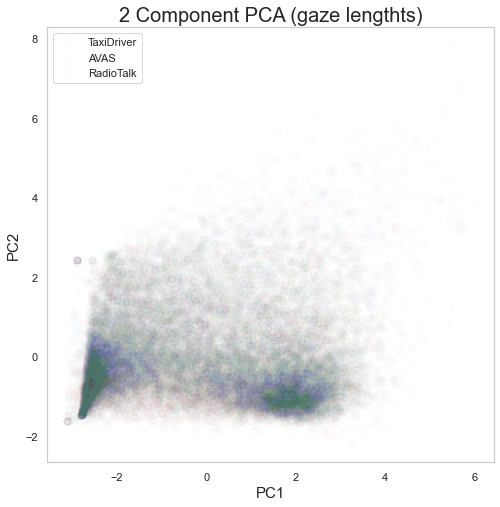

PCA variance ([PC1, PC2]): [0.50291223 0.19193069]
Total variance explained: 0.6948429162059457

PCA 2D over subjects for gaze counts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.325,-1.263,0.667,0.922,0.714,0.583,0.557
1,-1.320,0.801,-0.934,0.171,1.473,-0.654,-1.190
2,1.788,-1.223,0.094,-0.777,-1.134,-0.274,2.419
3,0.485,-0.832,1.267,1.422,-0.662,1.297,0.490
4,1.418,-1.332,1.875,-0.777,-1.134,0.890,1.086


Preview projected values:


,PC1,PC2
0,1.343,1.309
1,-2.493,0.772
2,2.432,-0.682
3,2.248,0.803
4,3.026,-1.074


Include target value:


,PC1,PC2,condition
0,1.343,1.309,TaxiDriver
1,-2.493,0.772,AVAS
2,2.432,-0.682,RadioTalk
3,2.248,0.803,AVAS
4,3.026,-1.074,TaxiDriver


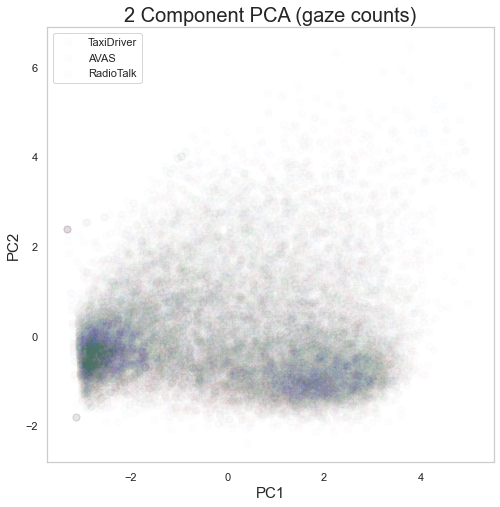

PCA variance ([PC1, PC2]): [0.53349856 0.18876269]
Total variance explained: 0.7222612468503153


In [33]:
# set non-interactive plot (default)
%matplotlib inline
print("PCA 2D over subjects for gaze lengthts:")
pca_2d(gaze_levs, "(gaze lengthts)")
print()
print("PCA 2D over subjects for gaze counts:")
pca_2d(gaze_cevs, "(gaze counts)")

__Compute and project LDA (2D, 2 components) over subjects__

LDA 2D over subjects for gaze lengthts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.164,-1.159,0.301,1.146,0.722,-0.073,1.428
1,-1.192,0.411,-0.897,-0.185,1.569,-0.668,-0.877
2,2.160,-1.234,-0.598,-0.659,-0.965,-0.594,0.824
3,0.219,-0.940,1.023,2.896,-0.816,0.703,3.318
4,1.568,-1.245,1.503,-0.659,-0.965,0.897,0.898


Preview projected values:


,LD1,LD2
0,-1.582,0.821
1,-0.609,-1.297
2,0.048,1.721
3,-1.121,2.745
4,-0.384,0.618


Include target value:


,LD1,LD2,condition
0,-1.582,0.821,TaxiDriver
1,-0.609,-1.297,AVAS
2,0.048,1.721,RadioTalk
3,-1.121,2.745,AVAS
4,-0.384,0.618,TaxiDriver


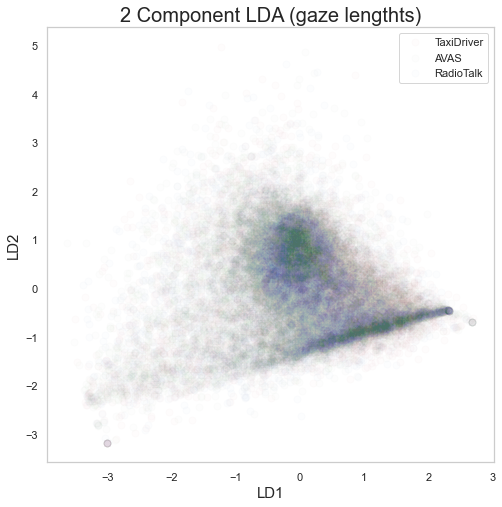

LDA variance ([LD1, LD2]): [0.91534512 0.08465488]
Total variance explained: 1.0

LDA 2D over subjects for gaze counts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.325,-1.263,0.667,0.922,0.714,0.583,0.557
1,-1.320,0.801,-0.934,0.171,1.473,-0.654,-1.190
2,1.788,-1.223,0.094,-0.777,-1.134,-0.274,2.419
3,0.485,-0.832,1.267,1.422,-0.662,1.297,0.490
4,1.418,-1.332,1.875,-0.777,-1.134,0.890,1.086


Preview projected values:


,LD1,LD2
0,-1.569,0.653
1,-0.903,-1.006
2,0.467,1.357
3,0.076,1.112
4,0.077,0.441


Include target value:


,LD1,LD2,condition
0,-1.569,0.653,TaxiDriver
1,-0.903,-1.006,AVAS
2,0.467,1.357,RadioTalk
3,0.076,1.112,AVAS
4,0.077,0.441,TaxiDriver


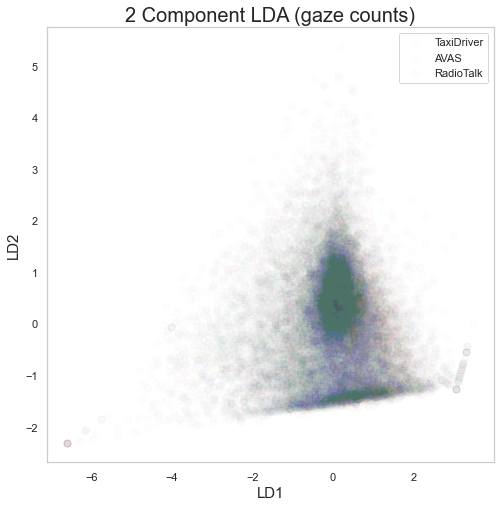

LDA variance ([LD1, LD2]): [0.88847797 0.11152203]
Total variance explained: 1.0


In [34]:
# set non-interactive plot (default)
%matplotlib inline
print("LDA 2D over subjects for gaze lengthts:")
lda_2d(gaze_levs, "(gaze lengthts)")
print()
print("LDA 2D over subjects for gaze counts:")
lda_2d(gaze_cevs, "(gaze counts)")

__Compute and project PCA (3D, 3 components) over subjects__

PCA 3D over subjects for gaze lengthts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.164,-1.159,0.301,1.146,0.722,-0.073,1.428
1,-1.192,0.411,-0.897,-0.185,1.569,-0.668,-0.877
2,2.160,-1.234,-0.598,-0.659,-0.965,-0.594,0.824
3,0.219,-0.940,1.023,2.896,-0.816,0.703,3.318
4,1.568,-1.245,1.503,-0.659,-0.965,0.897,0.898


Preview projected values:


,PC1,PC2,PC3
0,1.327,1.645,-0.650
1,-2.181,0.913,-0.602
2,1.577,-1.156,-1.283
3,3.390,2.232,1.176
4,2.748,-1.080,-0.493


Include target value:


,PC1,PC2,PC3,condition
0,1.327,1.645,-0.650,TaxiDriver
1,-2.181,0.913,-0.602,AVAS
2,1.577,-1.156,-1.283,RadioTalk
3,3.390,2.232,1.176,AVAS
4,2.748,-1.080,-0.493,TaxiDriver


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
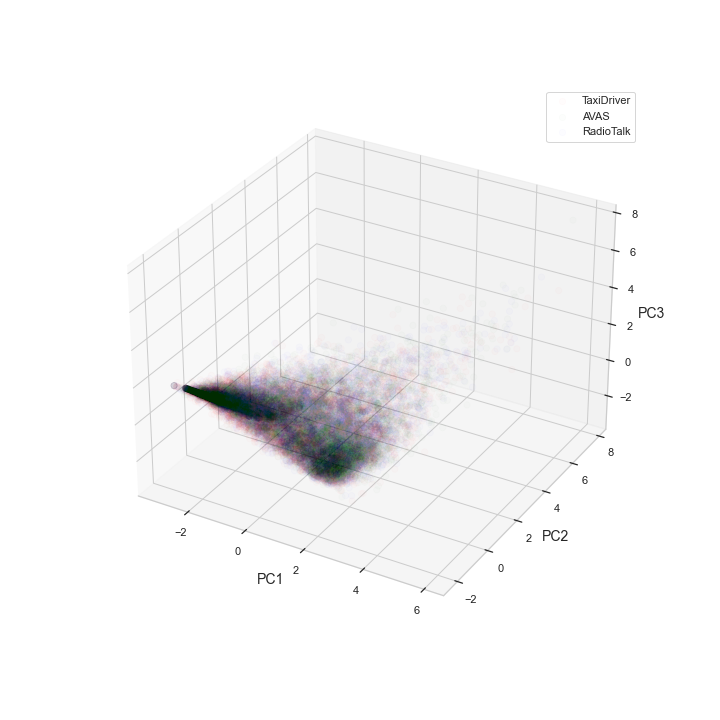

PCA variance ([PC1, PC2, PC3]): [0.50291223 0.19193069 0.11520006]
Total variance explained: 0.8100429756447413

PCA 3D over subjects for gaze counts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.325,-1.263,0.667,0.922,0.714,0.583,0.557
1,-1.320,0.801,-0.934,0.171,1.473,-0.654,-1.190
2,1.788,-1.223,0.094,-0.777,-1.134,-0.274,2.419
3,0.485,-0.832,1.267,1.422,-0.662,1.297,0.490
4,1.418,-1.332,1.875,-0.777,-1.134,0.890,1.086


Preview projected values:


,PC1,PC2,PC3
0,1.343,1.309,-0.176
1,-2.493,0.772,0.276
2,2.432,-0.682,-2.079
3,2.248,0.803,0.992
4,3.026,-1.074,-0.487


Include target value:


,PC1,PC2,PC3,condition
0,1.343,1.309,-0.176,TaxiDriver
1,-2.493,0.772,0.276,AVAS
2,2.432,-0.682,-2.079,RadioTalk
3,2.248,0.803,0.992,AVAS
4,3.026,-1.074,-0.487,TaxiDriver


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
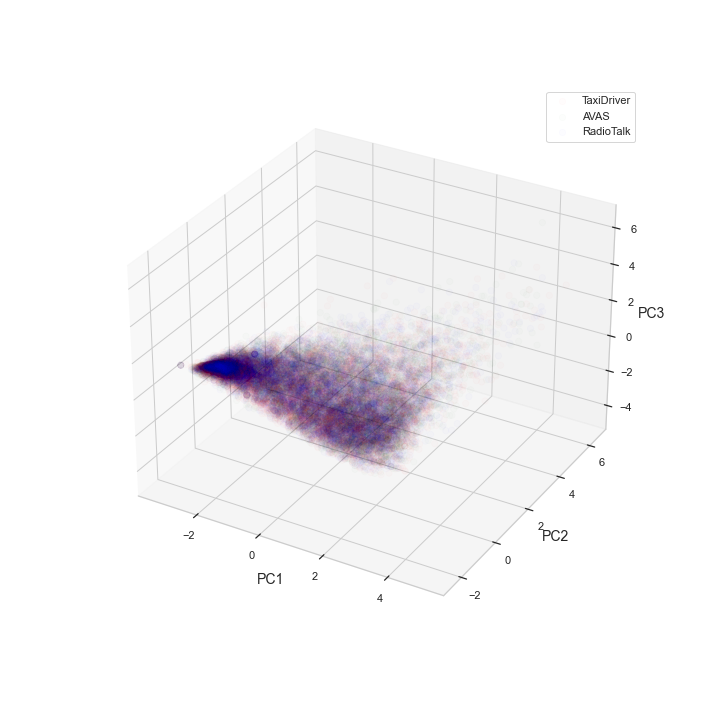

PCA variance ([PC1, PC2, PC3]): [0.53349856 0.18876269 0.09517312]
Total variance explained: 0.8174343653503648


In [35]:
# set interactive plot
%matplotlib widget
print("PCA 3D over subjects for gaze lengthts:")
pca_3d(gaze_levs, "(gaze lengthts)")
print()
print("PCA 3D over subjects for gaze counts:")
pca_3d(gaze_cevs, "(gaze counts)")

__Compute and project LDA (3D, 3 components) over subjects__

In [36]:
# set interactive plot
%matplotlib widget
print("PCA 3D over subjects for gaze lengthts:")
lda_3d(gaze_levs, "(gaze lengthts)")
print()
print("PCA 3D over subjects for gaze counts:")
lda_3d(gaze_cevs, "(gaze counts)")

PCA 3D over subjects for gaze lengthts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.164,-1.159,0.301,1.146,0.722,-0.073,1.428
1,-1.192,0.411,-0.897,-0.185,1.569,-0.668,-0.877
2,2.160,-1.234,-0.598,-0.659,-0.965,-0.594,0.824
3,0.219,-0.940,1.023,2.896,-0.816,0.703,3.318
4,1.568,-1.245,1.503,-0.659,-0.965,0.897,0.898


ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

In [ ]:
# set interactive plot
%matplotlib widget
print("PCA 3D over subjects for gaze lengthts:")
pca_3d(gaze_levs, "(gaze lengthts)")
print()
print("PCA 3D over subjects for gaze counts:")
pca_3d(gaze_cevs, "(gaze counts)")

In [ ]:
print("PCA 2D over subjects for gaze lengthts:")
pca_2d(gaze_ltr, "(gaze lengthts)")
print()
print("PCA 2D over subjects for gaze counts:")
pca_2d(gaze_ctr, "(gaze counts)")

In [ ]:
print("LDA 2D over subjects for gaze lengthts:")
lda_2d(gaze_ltr, "(gaze lengthts)")
print()
print("LDA 2D over subjects for gaze counts:")
lda_2d(gaze_ctr, "(gaze counts)")